<a href="https://colab.research.google.com/github/cxbxmxcx/EvolutionaryDeepLearning/blob/main/EDL_11_4_NEAT_LunarLander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/CodeReclaimers/neat-python.git -q

In [ ]:
!apt-get install -y xvfb x11-utils
# install required python dependencies
!pip install gym[box2d]==0.17.* \
            pyvirtualdisplay==0.2.* \
            PyOpenGL==3.1.* \
            PyOpenGL-accelerate==3.1.* \
            mediapy \
            piglet -q

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 993 kB of archives.
After this operation, 2,982 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.10 [784 kB]
Fetched 993 kB in 0s (6,965 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 155639 fil

In [ ]:
import gym.wrappers
import matplotlib.pyplot as plt
import numpy as np
import random
import mediapy
import time
import multiprocessing

import neat

NUM_CORES = 8

env = gym.make('LunarLander-v2')

print("action space: {0!r}".format(env.action_space))
print("observation space: {0!r}".format(env.observation_space))


action space: Discrete(4)
observation space: Box(-inf, inf, (8,), float32)


In [ ]:
!echo $DISPLAY

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

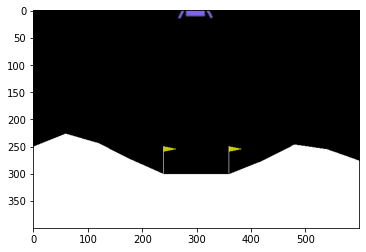

In [ ]:
import gym.wrappers
import matplotlib.pyplot as plt

env = gym.make('LunarLander-v2')
state = env.reset()
plt.imshow(env.render(mode='rgb_array'))

In [ ]:
%%writefile config
# neat-python configuration for the LunarLander-v2 environment on OpenAI Gym

[NEAT]
pop_size              = 150
# Note: the fitness threshold will never be reached because
# we are controlling the termination ourselves based on simulation performance.
fitness_criterion     = max
fitness_threshold     = 1000.0
reset_on_extinction   = 0

[LanderGenome]
num_inputs              = 8
num_hidden              = 8
num_outputs             = 4
initial_connection      = partial_direct 0.5
feed_forward            = True
compatibility_disjoint_coefficient = 1.0
compatibility_weight_coefficient   = 1.0
conn_add_prob           = 0.15
conn_delete_prob        = 0.1
node_add_prob           = 0.15
node_delete_prob        = 0.1
activation_default      = clamped
activation_options      = clamped
activation_mutate_rate  = 0.0
aggregation_default     = sum
aggregation_options     = sum
aggregation_mutate_rate = 0.0
bias_init_mean          = 0.0
bias_init_stdev         = 1.0
bias_replace_rate       = 0.02
bias_mutate_rate        = 0.8
bias_mutate_power       = 0.4
bias_max_value          = 30.0
bias_min_value          = -30.0
response_init_mean      = 1.0
response_init_stdev     = 0.0
response_replace_rate   = 0.0
response_mutate_rate    = 0.1
response_mutate_power   = 0.01
response_max_value      = 30.0
response_min_value      = -30.0

weight_max_value        = 30
weight_min_value        = -30
weight_init_mean        = 0.0
weight_init_stdev       = 1.0
weight_mutate_rate      = 0.8
weight_replace_rate     = 0.02
weight_mutate_power     = 0.4
enabled_default         = True
enabled_mutate_rate     = 0.01

[DefaultSpeciesSet]
compatibility_threshold = 3.0

[DefaultStagnation]
species_fitness_func = mean
max_stagnation       = 15
species_elitism      = 4

[DefaultReproduction]
elitism            = 2
survival_threshold = 0.2

Writing config


In [ ]:
class LanderGenome(neat.DefaultGenome):
    def __init__(self, key):
        super().__init__(key)
        self.discount = None

    def configure_new(self, config):
        super().configure_new(config)
        self.discount = 0.01 + 0.98 * random.random()

    def configure_crossover(self, genome1, genome2, config):
        super().configure_crossover(genome1, genome2, config)
        self.discount = random.choice((genome1.discount, genome2.discount))

    def mutate(self, config):
        super().mutate(config)
        self.discount += random.gauss(0.0, 0.05)
        self.discount = max(0.01, min(0.99, self.discount))

    def distance(self, other, config):
        dist = super().distance(other, config)
        disc_diff = abs(self.discount - other.discount)
        return dist + disc_diff

    def __str__(self):
        return f"Reward discount: {self.discount}\n{super().__str__()}"

In [ ]:
config = neat.Config(LanderGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     'config')

print(config.genome_type, config.genome_config,config.pop_size)

<class '__main__.LanderGenome'> <neat.genome.DefaultGenomeConfig object at 0x7f5dfccc2f90> 150


In [ ]:
env = gym.make('LunarLander-v2')
state = env.reset()
print(state)

[-0.00212317  1.3998296  -0.21506032 -0.492907    0.00246693  0.04871431
  0.          0.        ]


In [ ]:
key = "fred"
fred = config.genome_type(key)
fred.configure_new(config.genome_config)

net = neat.nn.FeedForwardNetwork.create(fred, config)
action = net.activate(state)
print(action)

env.reset()
state, reward, done, info = env.step(np.argmax(action))
print(state, reward, done, info)

[1.0, 1.0, 0.6975111370392931, 0.34042474145223606]
[-0.00628681  1.4041693  -0.3179596  -0.16285734  0.0072127   0.07128145
  0.          0.        ] -1.0459071007763612 False {}


In [ ]:
#@title Simulation Options { run: "auto" }
SIMULATION_ITERATIONS = 60 #@param {type:"slider", min:10, max:100, step:1}
SIMULATION_RUNS = 10 #@param {type:"slider", min:1, max:10, step:1}

frames = []
fitnesses = []
for run in range(SIMULATION_RUNS):  
  state = env.reset()
  fitness = 0
  for i in range(SIMULATION_ITERATIONS):
    action = net.activate(state)
    state, reward, done, info = env.step(np.argmax(action))  
    frames.append(env.render(mode='rgb_array'))  
    fitness += reward       
    if done: 
      fitnesses.append(fitness) 
      break 

print(fitnesses)
mediapy.show_video(frames, fps=30)

[-117.56662399329778, -97.36840701466815, -90.67317997154646]


In [ ]:
def compute_fitness(genome, net, episodes, min_reward, max_reward):
  m = int(round(np.log(0.01) / np.log(genome.discount)))
  discount_function = [genome.discount ** (m - i) for i in range(m + 1)]

  reward_error = []
  for score, data in episodes:
    # Compute normalized discounted reward.
    dr = np.convolve(data[:, -1], discount_function)[m:]
    dr = 2 * (dr - min_reward) / (max_reward - min_reward) - 1.0
    dr = np.clip(dr, -1.0, 1.0)

    for row, dr in zip(data, dr):
      observation = row[:8]
      action = int(row[8])
      output = net.activate(observation)
      reward_error.append(float((output[action] - dr) ** 2))

  return reward_error

In [ ]:
class PooledErrorCompute(object):
    def __init__(self, num_workers):
        self.num_workers = num_workers
        self.test_episodes = []
        self.generation = 0

        self.min_reward = -200
        self.max_reward = 200

        self.episode_score = []
        self.episode_length = []

    def simulate(self, nets):
        scores = []
        for genome, net in nets:
            observation = env.reset()
            step = 0
            data = []
            while 1:
                step += 1
                if step < 200 and random.random() < 0.2:
                    action = env.action_space.sample()
                else:
                    output = net.activate(observation)
                    action = np.argmax(output)

                observation, reward, done, info = env.step(action)
                data.append(np.hstack((observation, action, reward)))

                if done:
                    break

            data = np.array(data)
            score = np.sum(data[:, -1])
            self.episode_score.append(score)
            scores.append(score)
            self.episode_length.append(step)

            self.test_episodes.append((score, data))

        print("Score range [{:.3f}, {:.3f}]".format(min(scores), max(scores)))

    def evaluate_genomes(self, genomes, config):
        self.generation += 1

        t0 = time.time()
        nets = []
        for gid, g in genomes:
            nets.append((g, neat.nn.FeedForwardNetwork.create(g, config)))

        print("network creation time {0}".format(time.time() - t0))
        t0 = time.time()

        # Periodically generate a new set of episodes for comparison.
        if 1 == self.generation % 10:
            self.test_episodes = self.test_episodes[-300:]
            self.simulate(nets)
            print("simulation run time {0}".format(time.time() - t0))
            t0 = time.time()

        # Assign a composite fitness to each genome; genomes can make progress either
        # by improving their total reward or by making more accurate reward estimates.
        print("Evaluating {0} test episodes".format(len(self.test_episodes)))
        if self.num_workers < 2:
            for genome, net in nets:
                reward_error = compute_fitness(genome, net, self.test_episodes, self.min_reward, self.max_reward)
                genome.fitness = -np.sum(reward_error) / len(self.test_episodes)
        else:
            with multiprocessing.Pool(self.num_workers) as pool:
                jobs = []
                for genome, net in nets:
                    jobs.append(pool.apply_async(compute_fitness,
                                                 (genome, net, self.test_episodes,
                                                  self.min_reward, self.max_reward)))

                for job, (genome_id, genome) in zip(jobs, genomes):
                    reward_error = job.get(timeout=None)
                    genome.fitness = -np.sum(reward_error) / len(self.test_episodes)

        print("final fitness compute time {0}\n".format(time.time() - t0))

In [ ]:
pop = neat.Population(config)
stats = neat.StatisticsReporter()
pop.add_reporter(stats)
pop.add_reporter(neat.StdOutReporter(True))
# Checkpoint every 25 generations or 900 seconds.
pop.add_reporter(neat.Checkpointer(25, 900))

# Run until the winner from a generation is able to solve the environment
# or the user interrupts the process.
ec = PooledErrorCompute(NUM_CORES)
while 1:
  try:
    gen_best = pop.run(ec.evaluate_genomes, 5)

    # print(gen_best)

    #visualize.plot_stats(stats, ylog=False, view=False, filename="fitness.svg")

    plt.plot(ec.episode_score, 'g-', label='score')
    plt.plot(ec.episode_length, 'b-', label='length')
    plt.grid()
    plt.legend(loc='best')
    plt.savefig("scores.svg")
    plt.close()

    mfs = sum(stats.get_fitness_mean()[-5:]) / 5.0
    print("Average mean fitness over last 5 generations: {0}".format(mfs))

    mfs = sum(stats.get_fitness_stat(min)[-5:]) / 5.0
    print("Average min fitness over last 5 generations: {0}".format(mfs))

    # Use the best genomes seen so far as an ensemble-ish control system.
    best_genomes = stats.best_unique_genomes(3)
    best_networks = []
    for g in best_genomes:
        best_networks.append(neat.nn.FeedForwardNetwork.create(g, config))

    solved = True
    best_scores = []
    for k in range(100):
        observation = env.reset()
        score = 0
        step = 0
        while 1:
            step += 1
            # Use the total reward estimates from all five networks to
            # determine the best action given the current state.
            votes = np.zeros((4,))
            for n in best_networks:
                output = n.activate(observation)
                votes[np.argmax(output)] += 1

            best_action = np.argmax(votes)
            observation, reward, done, info = env.step(best_action)
            score += reward
            env.render()
            if done:
                break

        ec.episode_score.append(score)
        ec.episode_length.append(step)

        best_scores.append(score)
        avg_score = sum(best_scores) / len(best_scores)
        print(k, score, avg_score)
        if avg_score < 200:
            solved = False
            break

    if solved:
        print("Solved.")

        # Save the winners.
        for n, g in enumerate(best_genomes):
            name = 'winner-{0}'.format(n)
            with open(name + '.pickle', 'wb') as f:
                pickle.dump(g, f)

            #visualize.draw_net(config, g, view=False, filename=name + "-net.gv")
            #visualize.draw_net(config, g, view=False, filename=name + "-net-pruned.gv", prune_unused=True)

        break
  except KeyboardInterrupt:
      print("User break.")
      break

env.close()

Streaming output truncated to the last 5000 lines.
   219   13    37     -4.624    0.937    12
   220    0     5         --       --     0
Total extinctions: 0
Generation time: 72.052 sec (75.288 average)

 ****** Running generation 468 ****** 

network creation time 0.025053739547729492
Evaluating 452 test episodes
final fitness compute time 68.10629224777222

Population's average fitness: -1.01950 stdev: 4.82980
Best fitness: -0.29735 - size: (23, 36) - species 218 - id 62509
Average adjusted fitness: 0.987
Mean genetic distance 4.028, standard deviation 1.220
Population of 150 members in 5 species:
   ID   age  size   fitness   adj fit  stag
  ====  ===  ====  =========  =======  ====
   216   24    34     -0.525    0.995    20
   217   23    34     -0.649    0.993    22
   218   19    15     -1.489    0.975    18
   219   14    33     -1.577    0.973    13
   220    1    34     -0.298    1.000     0
Total extinctions: 0
Generation time: 68.666 sec (74.851 average)

 ****** Running 